In [1]:
### Setting up environment
import numpy as np
from numpy import sqrt
from scipy.linalg import expm, inv, cholesky as chol
import matplotlib.pyplot as plt

### Setting plotting style
plt.style.use('fivethirtyeight')
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Seed the RNG
np.random.seed(0)

In [2]:
def pad_to_square(A, n=None):
    nx, ny = A.shape
    if n is None:
        n = max(nx, ny)
    B = np.zeros((n,n))
    B[:nx, :ny] = A
    return B

# 1 Simulation Model $\mathcal{M^S}$

In [3]:
T2, T3 = 5, 1
P0 = np.diag([1,.1**2, .1**2])
Q = 2*.1**2
R = 1
F = np.array([[0, 1, 0],
              [0, -1/T2, 1/T2],
              [0, 0, -1/T3]])
L = np.array([[0],
              [0],
              [1/T3]])
G = np.array([[0],
              [0],
              [1]])
H = np.array([[1, 0, 0]])

# 2 Discretization

In [4]:
def c2d_determnistic(F, L, dt):
    n = F.shape[0]
    F1 = pad_to_square(np.hstack((F, L)), n=2*n)
    Fi1 = expm(F1*dt)
    Fi = Fi1[:n, :n]  # Upper left
    La = Fi1[:n, n:]  # Upper right
    
    return (Fi, La)

In [5]:
def c2d_stochastic(F, L, G, Q, dt):
    n = F.shape[0]
    G = pad_to_square(G, n=n)
    if isinstance(Q, (float, int)):
        Q = np.eye(n)*Q
    F2 = np.vstack((np.hstack((F, pad_to_square(G@Q@G.T, n=n))),
                    np.hstack((np.zeros(F.shape), -F.T))))
    Fi2 = expm(F2*dt)
    Fi12 = Fi2[:n, n:]  # Upper right
    Fi22 = Fi2[n:, n:]  # Lower right
    Ga = chol(Fi12 @ inv(Fi22), lower=False)
    Fi, La = c2d_determnistic(F, L, dt)
    
    return (Fi, La, Ga)

In [6]:
dt = .01

In [7]:
c2d_determnistic(F, L, dt)

(array([[1.00000000e+00, 9.99000666e-03, 9.96010313e-06],
        [0.00000000e+00, 9.98001999e-01, 1.98804123e-03],
        [0.00000000e+00, 0.00000000e+00, 9.90049834e-01]]),
 array([[3.32335397e-08, 0.00000000e+00, 0.00000000e+00],
        [9.96010313e-06, 0.00000000e+00, 0.00000000e+00],
        [9.95016625e-03, 0.00000000e+00, 0.00000000e+00]]))

In [8]:
c2d_stochastic(F, L, G, Q, dt)

(array([[1.00000000e+00, 9.99000666e-03, 9.96010313e-06],
        [0.00000000e+00, 9.98001999e-01, 1.98804123e-03],
        [0.00000000e+00, 0.00000000e+00, 9.90049834e-01]]),
 array([[3.32335397e-08, 0.00000000e+00, 0.00000000e+00],
        [9.96010313e-06, 0.00000000e+00, 0.00000000e+00],
        [9.95016625e-03, 0.00000000e+00, 0.00000000e+00]]),
 array([[6.30352113e-08, 1.57378158e-05, 1.04656845e-02],
        [0.00000000e+00, 4.07432794e-06, 8.14187293e-03],
        [0.00000000e+00, 0.00000000e+00, 4.71090429e-03]]))

# 3 Simulation of Stochastic System

In [9]:
tf = 100.
t = np.arange(0., tf+dt, dt)
n = t.size
#u = np.ones((3,1))*np.cos(2*np.pi/n*np.arange(n))
u = np.ones((3,n))

In [10]:
# Deterministic process
Fi, La = c2d_determnistic(F, L, dt)
xd = np.zeros((3, n))

for k in range(n-1):
    xd[:,k+1,np.newaxis] = Fi@xd[:,k,np.newaxis] + La@u[:,k,np.newaxis]

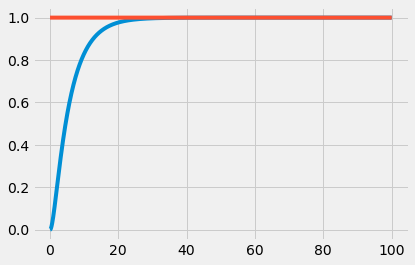

In [11]:
plt.plot(t, xd[1,:])
plt.plot(t,u[1,:])

In [12]:
Fi, La, Ga = c2d_stochastic(F, L, G, Q, dt)
v = sqrt(Q)*np.random.randn(3*n).reshape(3,n)
xs = np.zeros((3, n))

for k in range(n-1):
    xs[:,k+1,np.newaxis] = Fi@xd[:,k,np.newaxis] + La@u[:,k,np.newaxis] + Ga@v[:,k,np.newaxis]

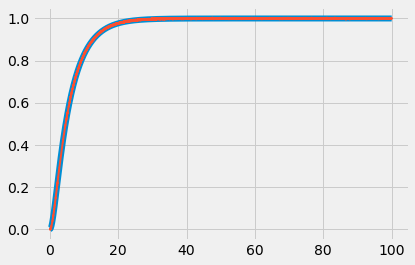

In [13]:
plt.plot(t, xd[1,:], lw=6)
plt.plot(t, xs[1,:], lw=2)

# 4 Optimal Kalman Filter

In [14]:
# Optimal Kalman Filter
dt_KF = 1.
t_KF = np.arange(0., tf+dt_KF, dt_KF)
n_KF = t_KF.size
Fi_KF, La_KF, Ga_KF = c2d_stochastic(F, L, G, Q, dt_KF)

x = xs[:,::100]  # true state vector
uk = u#[:,::100]
z = H.T*x + np.array([[0,0,1]]).T*sqrt(R)*np.random.randn(n_KF)  # measurements

x_bar = np.zeros(xs.shape)  # a-priori state vector estimate
x_hat = np.zeros(x.shape)  # a-posteriori est.
P_bar = np.zeros((n,3,3))  # a-priori covariance matrix estimate
P_hat = np.zeros((n_KF,3,3))  # a-posteriori est.
P_bar[0,...] = P_hat[0,...] = P0


In [15]:
I = np.eye(3)
Hk = pad_to_square(H)
Rk = np.eye(3)*R
Qk = Ga_KF@Ga_KF.T

In [20]:
for k in range(n-1):
    if k%100 == 0:
        # Compute Kalman gain
        K = P_bar[k,...]@Hk.T@inv(Hk@P_bar[k,...]@Hk.T + Rk)

        # Measurement update
        x_hat[:,k//100,np.newaxis] = x_bar[:,k,np.newaxis] + K@(z[:,k//100,np.newaxis] - Hk@x_bar[:,k,np.newaxis])
        P_hat[k//100,...] = (I - K@Hk)@P_bar[k,...]
    
    # Time update
    x_bar[:,k+1,np.newaxis] = Fi@x_hat[:,k//100,np.newaxis] + Ga@uk[:,k//100,np.newaxis]
    P_bar[k+1,...] = Fi@P_hat[k//100,...]@Fi.T + Qk
    


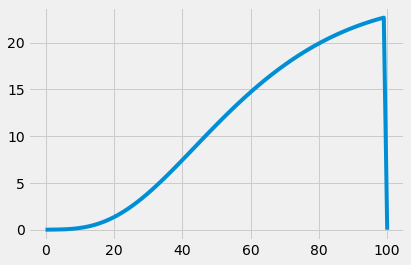

In [25]:
plt.plot(x_hat[2,:])
#plt.plot(uk[0,:])